In [1]:
# Import Required Libratries
import math
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow import keras

%matplotlib inline

In [2]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_TFLITE_QUANT = MODELS_DIR + 'mnist_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'mnist.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

In [59]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Filter intermediate values to scale for use in uC
train_images[train_images>200]=255
train_images[train_images<=200]=0

test_images[test_images>200]=255
test_images[test_images<=200]=0

train_images = train_images.reshape(60000,28,28,1)
test_images = test_images.reshape(10000,28,28,1)


print(test_images.shape)

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images.astype(np.float32)/255.0
test_images = test_images.astype(np.float32) /255.0

# Define the model architecture
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=4, kernel_size=(3, 3),strides=(3,3), activation='relu', input_shape=(28,28,1)),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=5,
  validation_data=(test_images, test_labels)
)


(10000, 28, 28, 1)
Epoch 1/5
1875/1875 [==============================] - 5s 3ms/step - loss: 1.5086 - accuracy: 0.5078 - val_loss: 0.6466 - val_accuracy: 0.7971
Epoch 2/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.6525 - accuracy: 0.7943 - val_loss: 0.5581 - val_accuracy: 0.8289
Epoch 3/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.5743 - accuracy: 0.8174 - val_loss: 0.5079 - val_accuracy: 0.8417
Epoch 4/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.5228 - accuracy: 0.8327 - val_loss: 0.4875 - val_accuracy: 0.8504
Epoch 5/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.5041 - accuracy: 0.8370 - val_loss: 0.4686 - val_accuracy: 0.8548


Number:  0


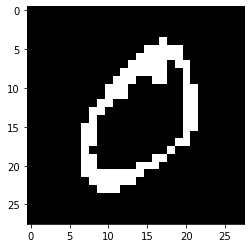

In [64]:
# Let Look at how the model perfromed
# Rerun the model to figure which test cases your model
#    predicted right and which ones it predicted wrong
# 
# Evaluating which data your model does well on which ones
#   need improvemt can focus your data collection and traing efforts 


index = np.random.randint(0,train_images.shape[2])
plt.imshow(train_images[index], cmap='gray')

print("Number: ", train_labels[index])


In [65]:
# Converter to tf-lite model  and model interger-only quanization

# Generate non-quantized model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


# Generate Dataset for quantization 
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

# Create tf-lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

# Save models to disk
# Save the model to disk
open(MODEL_TFLITE, "wb").write(tflite_model)
open(MODEL_TFLITE_QUANT, "wb").write(tflite_model_quant)

INFO:tensorflow:Assets written to: /tmp/tmpiyf2khpq/assets


INFO:tensorflow:Assets written to: /tmp/tmpiyf2khpq/assets


INFO:tensorflow:Assets written to: /tmp/tmpu2c0m01j/assets


INFO:tensorflow:Assets written to: /tmp/tmpu2c0m01j/assets


3560

In [66]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions


In [67]:
# Function to test model on one image

# Change this to test a different image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global test_labels

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(test_images[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)


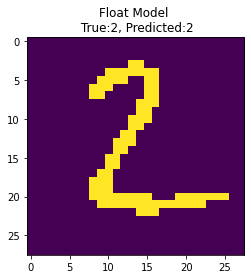

In [68]:
# Test the float model
test_model(MODEL_TFLITE, test_image_index, model_type="Float")


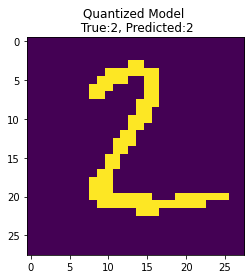

In [69]:
# Evaluate single image on quantized model
test_model(MODEL_TFLITE_QUANT, test_image_index, model_type="Quantized")


In [70]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_labels

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))


In [71]:
# Evaluate float model on all images
evaluate_model(MODEL_TFLITE, model_type="Float")
evaluate_model(MODEL_TFLITE_QUANT, model_type="Quantized")


Float model accuracy is 85.4800% (Number of test samples=10000)
Quantized model accuracy is 85.5500% (Number of test samples=10000)


In [73]:
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE_MICRO.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

# Print the C source file
!cat {MODEL_TFLITE_MICRO}

unsigned char models_mnist_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x1c, 0x00, 0x14, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x00, 0x00, 0x28, 0x00, 0x00, 0x00, 0xb4, 0x00, 0x00, 0x00,
  0x28, 0x00, 0x00, 0x00, 0x5c, 0x00, 0x00, 0x00, 0x54, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0xac, 0x03, 0x00, 0x00, 0xc4, 0x02, 0x00, 0x00,
  0xf4, 0x01, 0x00, 0x00, 0x6c, 0x01, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0xb0, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0xbc, 0x11, 0x00, 0x00,
  0xb8, 0x11, 0x00, 0x00, 0xbc, 0x10, 0x00, 0x00, 0x1c, 0x10, 0x00, 0x00,
  0xac, 0x0f, 0x00, 0x00, 0x54, 0x05, 0x00, 0x00, 0x64, 0x04, 0x00, 0x00,
  0xa0, 0x11, 0x00, 0x00, 0x9c, 0x11, 0x00, 0x00, 0x98, 0x11, 0x00, 0x00,
  0x94, 0x11, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x0c, 0x00

In [14]:
# create test images for .
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.
